In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import pickle

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
bank_holidays = [
    [1, 1],
    [4, 19],
    [4, 21],
    [4, 25],
    [5, 1],
    [6, 10],
    [6, 20],
    [8, 15],
    [10, 5],
    [11, 1],
    [12, 1],
    [12, 8],
    [12, 25]
]

In [3]:
def mean_confidence_interval(X, confidence=0.95):
    m  = np.mean(X, axis=0)
    se = scipy.stats.sem(X, axis=0)
    h  = se * scipy.stats.t.ppf((1 + confidence) / 2., X.shape[0] - 1)
    return m, m - h, m + h

In [4]:
def read_sheet(data_file, sheet_name, header=(0,)):
    df = pd.read_excel(data_file, sheet_name=sheet_name, parse_dates=True, header=header)
    
    if isinstance(df.columns, pd.MultiIndex):
        cols = []
        for col in df.columns.to_list():
            if 'Unnamed' in col[0]:
                cols.append(col[1])
            else:
                cols.append(col[0].split(' ')[-1] + '_' + col[1].split(' ')[0])
        df.columns = cols

    if 'date' in df.columns:
        df['datetime'] = [pd.Timestamp(year=d.year, month=d.month, day=d.day, 
                                       hour=t.hour, minute=t.minute) for d,t in zip(df.date, df.time)]
        df.drop(['date', 'time'], axis=1, inplace=True)
    elif 'datetime (epoch)' in df.columns:
        datetimes = [time.gmtime(dt) for dt in df['datetime (epoch)']]
        df['datetime'] = [pd.Timestamp(year = dt.tm_year, month = dt.tm_mon, day = dt.tm_mday, 
                                 hour = dt.tm_hour, minute  = dt.tm_min) for dt in datetimes]
        df.drop('datetime (epoch)', axis=1, inplace=True)

    df['weekday'] = [d.weekday() for d in df['datetime']]
    df['weekend'] = [d.weekday() in (5,6) for d in df['datetime']]
    df['holiday'] = False
    for holiday in bank_holidays:
        idx = np.array([timestamp.month == holiday[0] and timestamp.day == holiday[1] \
                        for timestamp in df['datetime']])
        df.loc[idx, 'holiday'] = True

    cols = df.columns.tolist()
    cols = cols[-4:] + cols[:-4]
    df = df[cols]
    df.rename({col: col.split(' ')[0] for col in cols}, axis='columns', inplace=True)
    return df

In [5]:
xls_file = 'data1.xlsx'
pkl_file = os.path.splitext(xls_file)[0] + '.pkl'
reload = False
if os.path.isfile(pkl_file) and not reload:
    data = pickle.load(open(pkl_file, 'rb'))
    building_energy = data['full']['building_energy']
    building_sensor = data['full']['building_sensor']
    weather_data = data['full']['weather_data']
    zones = data['full']['zones']
    sensors = data['full']['sensors']
else:
    building_energy = read_sheet(xls_file, 'building_energy')
    building_sensor = read_sheet(xls_file, 'building_sensor')
    weather_data = read_sheet(xls_file, 'weather_data')
    zones = {i+1: read_sheet(xls_file, sheet_name=f'zone#{i+1}_energy', header=(0,1)) for i in range(5)}
    sensors = {i+1: read_sheet(xls_file, sheet_name=f'zone#{i+1}_sensor') for i in range(3)}
    data = {'full': {
        'building_energy': building_energy,
        'building_sensor': building_sensor,
        'weather_data': weather_data,
        'zones': zones,
        'sensors': sensors
    }}
    pickle.dump(data, open(pkl_file, 'wb'))

In [6]:
t0 = datetime.datetime.combine(datetime.date.today(), building_energy['datetime'][0].to_pydatetime().time())
t1 = datetime.datetime.combine(datetime.date.today(), building_energy['datetime'][1].to_pydatetime().time())
time_step = int((t1 - t0).total_seconds() / 60) # [min]
samples_per_day = 24 * 60 // time_step
num_samples =  building_energy.shape[0]
num_days = num_samples // samples_per_day
print(f'Time step: {time_step} minutes.')
print(f'Number of days: {num_days}.')

Time step: 5 minutes.
Number of days: 365.


In [7]:
building_energy[::samples_per_day][:14]

,datetime,weekday,weekend,holiday,consumption,generation
0,2019-01-01 00:05:00,1,False,True,2985,0
288,2019-01-02 00:05:00,2,False,False,2969,0
576,2019-01-03 00:05:00,3,False,False,2279,0
864,2019-01-04 00:05:00,4,False,False,2257,0
1152,2019-01-05 00:05:00,5,True,False,2947,0
1440,2019-01-06 00:05:00,6,True,False,2613,0
1728,2019-01-07 00:05:00,0,False,False,2288,0
2016,2019-01-08 00:05:00,1,False,False,2793,0
2304,2019-01-09 00:05:00,2,False,False,3576,0
2592,2019-01-10 00:05:00,3,False,False,3696,0


In [8]:
data['weekdays'] = {}
data['holidays'] = {}
for key,value in data['full'].items():
    if isinstance(value, pd.DataFrame):
        df = value
        weekdays = (df['weekday'] < 5) & (df['holiday'] == False)
        holidays = (df['weekday'] >= 5) | (df['holiday'] == True)
        data['weekdays'][key] = df.loc[weekdays, :]
        data['holidays'][key] = df.loc[holidays, :]
    elif isinstance(value, dict):
        data['weekdays'][key] = {}
        data['holidays'][key] = {}
        for subkey,df in value.items():
            weekdays = (df['weekday'] < 5) & (df['holiday'] == False)
            holidays = (df['weekday'] >= 5) | (df['holiday'] == True)
            data['weekdays'][key][subkey] = df.loc[weekdays, :]
            data['holidays'][key][subkey] = df.loc[holidays, :]


In [9]:
building_consumption = {}
building_generation = {}
building_temperature = {}
for key,value in data.items():
    tmp = value['building_energy']['consumption'].to_numpy()
    building_consumption[key] = np.reshape(tmp, [tmp.size // samples_per_day, samples_per_day], order='C')
    tmp = value['building_energy']['generation'].to_numpy()
    building_generation[key] = np.reshape(tmp, [tmp.size // samples_per_day, samples_per_day], order='C')
    tmp = value['building_sensor']['temperature'].to_numpy()
    building_temperature[key] = np.reshape(tmp, [tmp.size // samples_per_day, samples_per_day], order='C')

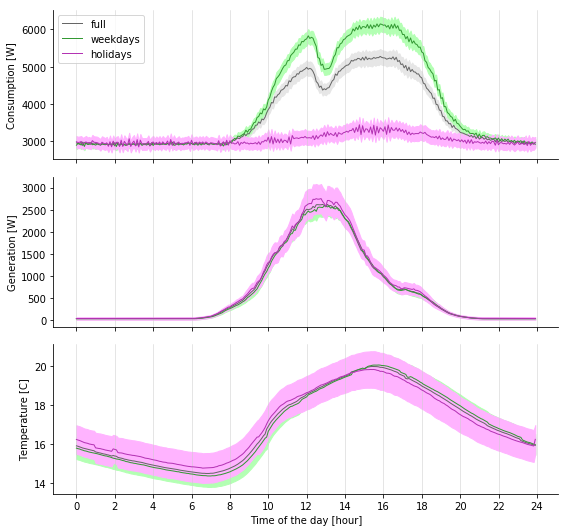

In [10]:
t = np.arange(samples_per_day) * time_step / 60
fig,ax = plt.subplots(3, 1, figsize=(8, 2.5 * 3), sharex=True)
cmap = {'full': [.4,.4,.4], 'weekdays': [.2,.6,.2], 'holidays': [.7,.2,.7]}
offset = .5 + np.zeros(3)
for key,value in building_consumption.items():
    m, lower, upper = mean_confidence_interval(value)
    col = np.min([[1,1,1], cmap[key] + np.array(offset)], axis=0)
    ax[0].fill_between(t, lower, upper, color=col)
    ax[0].plot(t, m, color=cmap[key], lw=1, label=key)
for key,value in building_generation.items():
    m, lower, upper = mean_confidence_interval(value)
    col = np.min([[1,1,1], cmap[key] + np.array(offset)], axis=0)
    ax[1].fill_between(t, lower, upper, color=col)
    ax[1].plot(t, value.mean(axis=0), color=cmap[key], lw=1, label=key)
for key,value in building_temperature.items():
    m, lower, upper = mean_confidence_interval(value)
    col = np.min([[1,1,1], cmap[key] + np.array(offset)], axis=0)
    ax[2].fill_between(t, lower, upper, color=col)
    ax[2].plot(t, value.mean(axis=0), color=cmap[key], lw=1, label=key)
for a in ax:
    a.grid(True, which='major', axis='x', color=[.8,.8,.8], linestyle='-', linewidth=0.5)
    for side in 'top','right':
        a.spines[side].set_visible(False)
ax[-1].set_xlabel('Time of the day [hour]')
ax[0].set_ylabel('Consumption [W]')
ax[1].set_ylabel('Generation [W]')
ax[2].set_ylabel('Temperature [C]')
ax[1].set_xticks(np.r_[0 : 25 : 2])
ax[0].legend(loc='upper left')
fig.tight_layout()

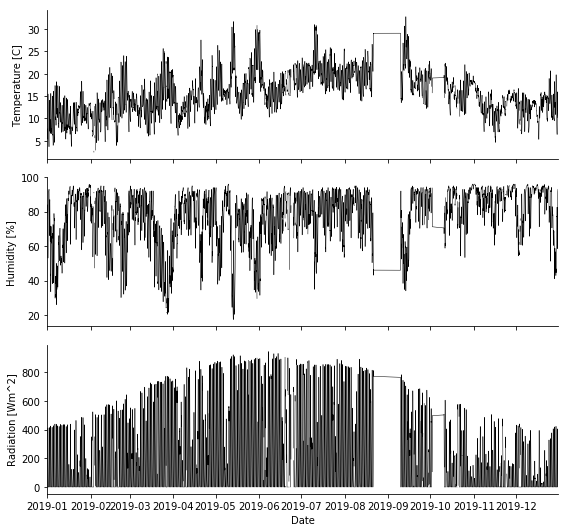

In [11]:
fig,ax = plt.subplots(3, 1, figsize=(8, 2.5 * 3), sharex=True)
window_size = 3 * 60
columns = 'temperature', 'humidity', 'radiation'
units = 'C', '%', 'Wm^2'
for i,(column,unit) in enumerate(zip(columns,units)):
    ax[i].plot(weather_data['datetime'],
               weather_data[column].rolling(window_size // time_step, win_type='triang').mean(),
               'k', lw=0.5)
    ax[i].set_ylabel(column.capitalize() + f' [{unit}]')
    for side in 'top','right':
        ax[i].spines[side].set_visible(False)
ax[-1].set_xlabel('Date')
start = pd.Timestamp(year=2019, month=1, day=1)
stop = pd.Timestamp(year=2019, month=12, day=31)
ax[-1].set_xlim([start, stop])
fig.tight_layout()

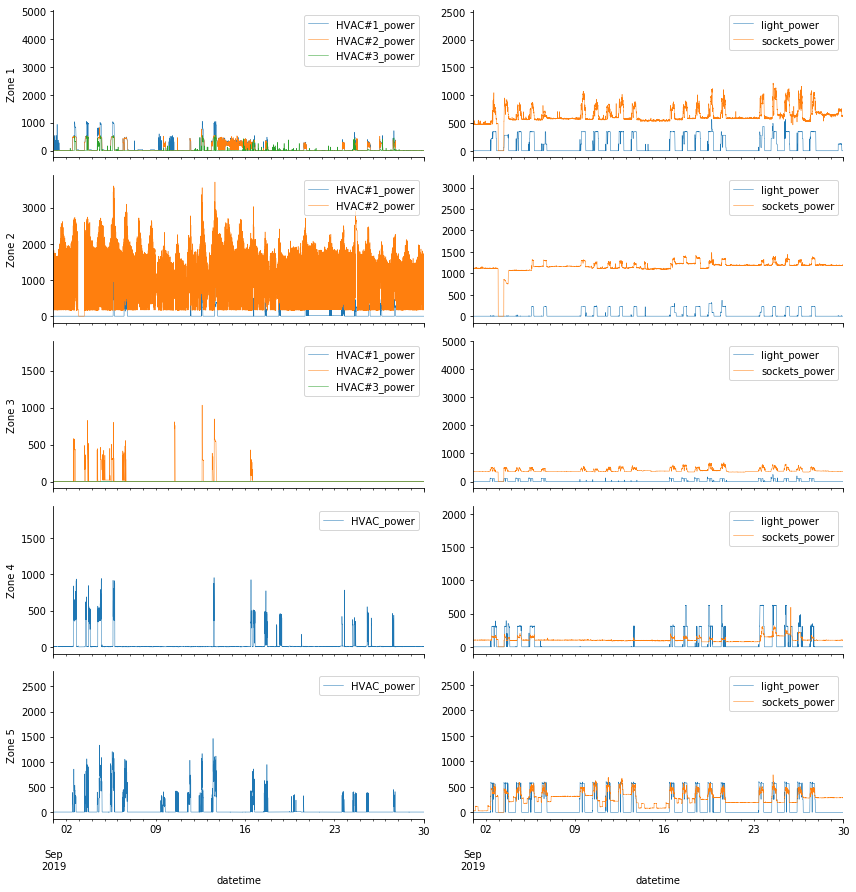

In [16]:
N_zones = len(zones)
fig,ax = plt.subplots(N_zones, 2, figsize=(12, 2.5 * N_zones), sharex=True)
for a,(key,zone) in zip(ax[:,0], zones.items()):
    N_HVAC = np.sum(['HVAC' in col for col in zone.columns]) // 3
    if N_HVAC > 1:
        zone.plot(x='datetime', y=[f'HVAC#{i+1}_power' for i in range(N_HVAC)], lw=0.5, ax=a)
    else:
        zone.plot(x='datetime', y='HVAC_power', lw=0.5, ax=a)
    for side in 'right','top':
        a.spines[side].set_visible(False)
    a.set_ylabel(f'Zone {key}')
#     a.set_ylim([0,4000])
for a,(key,zone) in zip(ax[:,1], zones.items()):
    zone.plot(x='datetime', y=['light_power','sockets_power'], lw=0.5, ax=a)
    for side in 'right','top':
        a.spines[side].set_visible(False)
#     a.set_ylim([0,4000])
start = pd.Timestamp(year=2019, month=9, day=1)
stop = pd.Timestamp(year=2019, month=9, day=30)
ax[0,0].set_xlim([start, stop])
fig.tight_layout()